In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [4]:
sns.set(rc={'figure.figsize':(12.0,8.0)})

# Market Simulation

### The value investors' expectation value for the stock

Obviously, the *true value* is a prior, not known to anybody. It's here to help simulating the value investors' reasoning

In [5]:
## cyclic behaviour with an upwards trend
def cyclic_upwards(t):
    return (10.0 + 
            np.sin(t/700. + 1.2) + 
            .6*np.sin(t/250.-1.4) + 
            #.9 * np.sin(t/110.) + 
            t/1000)

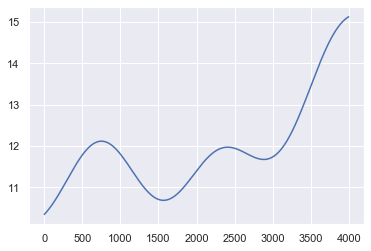

In [8]:
arange = np.arange(4000)
sns.set(rc={'figure.figsize':(6.0,4.0)})
sns.lineplot(arange, cyclic_upwards(arange));

In [9]:
from stockmarket import Stock, Bid, Ask, OrderStatus, Market

The noise represents uncertainty in the *true value* of the stock

In [13]:
aapl = Stock('AAPL', cyclic_upwards, noise = .4)
aapl.value(10)

10.437663787482261

---
### The Market

In [14]:
market = Market([aapl])

In [18]:
bid, ask = market.price_for('AAPL')
bid, ask

(9.959, 9.759)

### The Investors

In [15]:
from investors import MomentumInvestor, ValueInvestor, SignalInvestor

In [16]:
i_m = MomentumInvestor("momentum", 1000)    
i_s = SignalInvestor("signal", 1000)
i_v = ValueInvestor("value", 1000)
i_m, i_s, i_v

(momentum(1000, 200), signal(1000, 200), value(1000, 200))

### Order Flow
You can observe the prices change as orders get processed. Orders that have been defered, don't change the price when they're executed. Needs to be discussed, I guess...;-(

#### Execute a matching order

In [23]:
market.execute(Ask(i_m, "AAPL", 10, ask))
i_m, i_v, market.orders, market.price_for('AAPL')

(momentum(1487.9499999999996, 150),
 value(901.41, 210),
 {'ask': {'AAPL': {}}, 'bid': {'AAPL': {}}},
 (9.859, 9.659))

#### Defer a non-matching order

In [24]:
bid, ask = market.price_for('AAPL')
market.execute(Ask(i_m, "AAPL", 10, ask+0.1))
market.execute(Ask(i_m, "AAPL", 10, ask+0.1))
i_m, i_v, market.orders, market.price_for('AAPL')

(momentum(1487.9499999999996, 150),
 value(901.41, 210),
 {'ask': {'AAPL': {'760ab265592a4919a3056d2b39aea603': momentum:AAPL:10:9.759,
    '25b71439cc7049afa6d00f4738baab87': momentum:AAPL:10:9.759}},
  'bid': {'AAPL': {}}},
 (9.859, 9.659))

#### Process defered orders once prices match

In [25]:
bid, ask = market.price_for('AAPL')
market.execute(Bid(i_v, "AAPL", 10, bid))
i_m, i_v, market.orders, market.price_for('AAPL')

(momentum(1683.1299999999994, 130),
 value(802.8199999999999, 220),
 {'ask': {'AAPL': {}}, 'bid': {'AAPL': {}}},
 (9.959, 9.759))

### A market driven by momentum investors

In [26]:
investors = []
for i in range(100):
    wr, wm = [np.random.normal(mu, sigma) for mu, sigma in [(0.2, 0.1), (.7, .3)]]
    span = np.random.randint(10, 40)
    investor = MomentumInvestor("m-%s" % i, 1000, wr, wm, span)
    investors.append(investor)

In [28]:
market = Market([Stock('AAPL', cyclic_upwards, noise = .2)])

In [29]:
for i in range(40):
    for investor in investors:
        investor.act(market)

In [30]:
h = market.history_for('AAPL')
t = np.arange(len(h))

### Moving Average and true value
In our model - and who knows? Maybe also in reality - the 800 points moving average approximates the unknown prior *true value* of the stock.

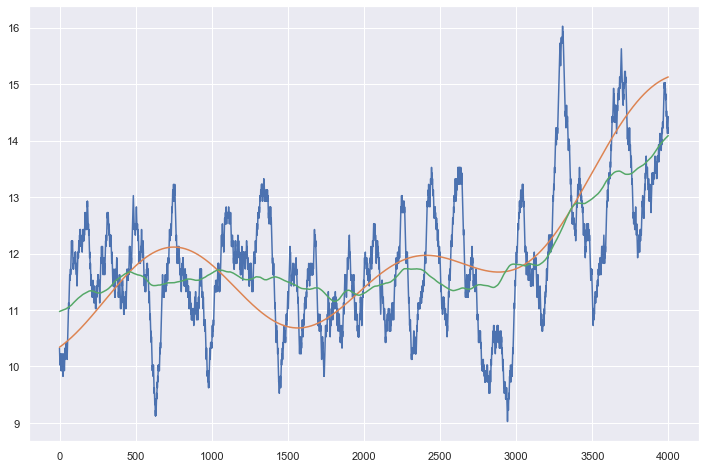

In [34]:
extended = np.hstack([np.ones(400)*h[0], h, np.ones(400)*h[-1]])
N = 800
weights = np.ones(N) / N
avg = np.convolve(extended, weights, mode='same')[400:-400]

sns.set(rc={'figure.figsize':(12.0,8.0)})
sns.lineplot(t, h)
sns.lineplot(t, cyclic_upwards(t))
sns.lineplot(t,avg);

### First Conclusions about Momentum
Even a larger degree of reasoning doesn't make a momentum investor successfull. It's still driven by chance and nothing else. Below, we look at wealth aquired vs degree of reasoning. Reasoning, in this context, is the tendency towards buying undervalued stock and selling overvalued stock.

In [39]:
wealth = [inv.wealth for inv in investors]
reason = [inv.w_reason - inv.w_momentum for inv in investors]
span = [inv.trend_span for inv in investors]

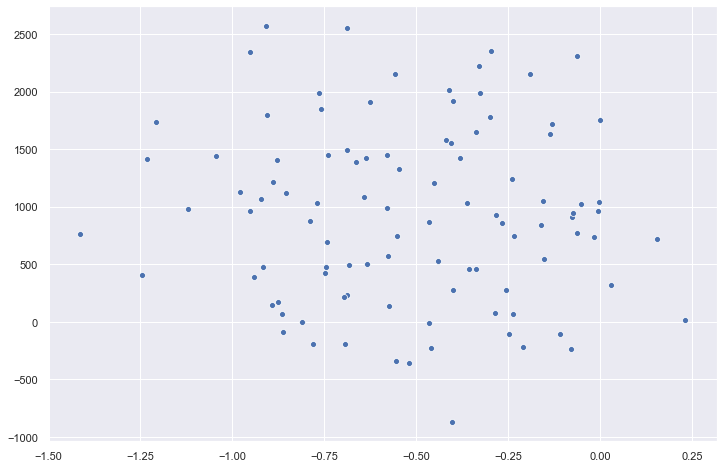

In [40]:
sns.scatterplot(reason, wealth);

### Exploiting a signal
####  (Make sure to have a stop loss in place)

Now we look at a technical investor:

In [41]:
from signals import BandSignal

We feed the pricing history of 'AAPL' in to a signal detector

In [44]:
BandSignal?

Init signature:
BandSignal(
    major_stats_width,
    minor_stats_width,
    history,
    std_excess=1.0,
    drop_from_high=0.05,
    rise_from_low=0.05,
)
Docstring:      <no docstring>
Init docstring:
Create a signal recommender
params: 
moving_stats_width: number of element to keep in moving stats
history: history to initialize the stats
std_excess: factor to apply to std of the differences wr moving average to arrive
    at a threshold for kicking off the watch phase
down_threshold: ratio of downturn from recent maximum difference to kick off the 'SELL' phase
up_threshold: ratio of upturn from recent minimum difference to kick off the 'BUY' phase

Example: With a current std of the differences of 2.5 and std_excess of 1.2, the algorithm
would start watching out for the SELL signal, when the current difference (=the head) is above 
1.2 * 2.5 = 3.0. Let's assume the head continues upwards until 4 before it loses momentum.
With a drop_from_high of 0.1 (10% down from the highest diff

In [46]:
h = market.history_for('AAPL')
from_ = 800
until = 4000
mjsw = from_
mnsw = 40
signal = BandSignal(major_stats_width=mjsw, std_excess=1.5,
                    minor_stats_width=mnsw,
                    history=h[:from_])
criticals = []
for t in range(from_, until):
    res, package = signal.next_value(h[t])
    if res != 'HOLD':
        criticals.append((t, res, package))

### Visualize the recommendations
These a are the pivotal points

In [47]:
cx, cy, cs = np.transpose([ [c[0], c[2][0], c[1]] for c in criticals])
cx, cy = cx.astype(float), cy.astype(float)
cx, cy, cs

(array([1007., 1375., 1479., 2281., 2468., 2653., 2841., 2970., 3327.,
        3728.]),
 array([10.625, 12.625, 10.625, 12.025, 12.725, 12.425, 10.225,  9.925,
        14.225, 14.325]),
 array(['BUY', 'SELL', 'BUY', 'SELL', 'SELL', 'SELL', 'BUY', 'BUY', 'SELL',
        'SELL'], dtype='<U32'))

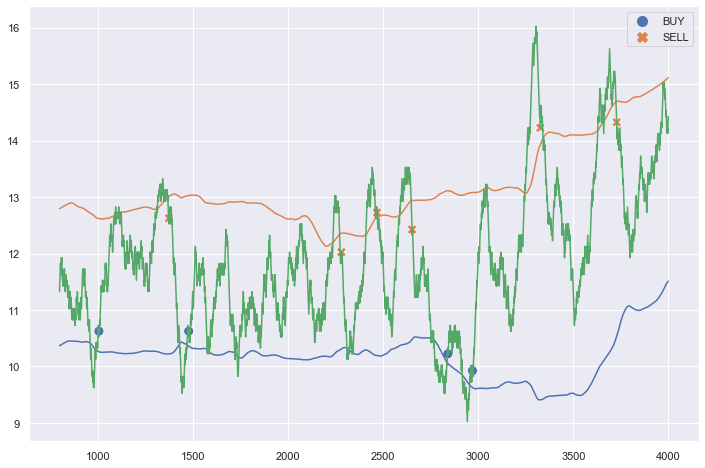

In [48]:
x = range(from_, from_ + len(signal.values))
#sns.lineplot(x, signal.avgs)
sns.set(rc={'figure.figsize':(12.0,8.0)})
sns.lineplot(x, np.add(signal.avgs, signal.l_w))
sns.lineplot(x, np.add(signal.avgs, signal.u_w))
sns.lineplot(x, signal.values)
sns.scatterplot(cx, cy, style=cs, hue=cs, sizes=[100, 100], size=cs);

It's the crossings of the 100-point moving average that trigger the recommendations

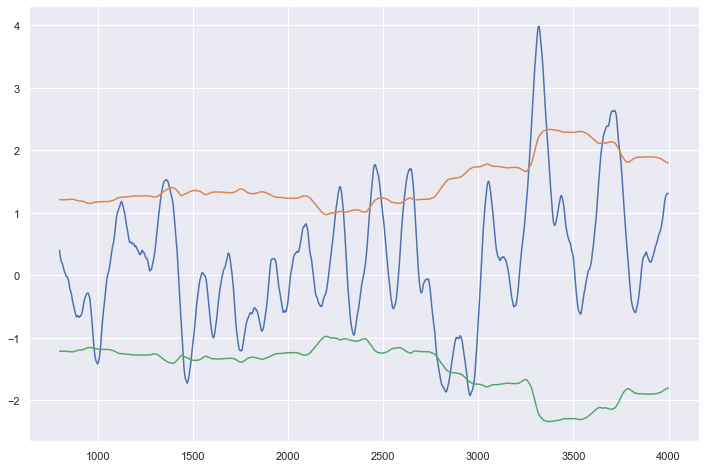

In [49]:
x = range(from_, from_ + len(signal.diffs))
sns.lineplot(x, signal.heads);
sns.lineplot(x, signal.u_w);
sns.lineplot(x, signal.l_w);